In [1]:
%pip install tensorflow numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import random

In [56]:
class GaitDataset(Dataset):
    def __init__(self, folder_path, crop_size, noise_level, no_crops):
        self.data = []
        self.labels = []
        self.crop_size = crop_size
        self.noise_level = noise_level
        self.label_dict = {"hersh": 0, "nate": 1, "ryan": 2}

        # First pass: Calculate mean and std for normalization
        all_data = []
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, "r") as file:
                    content = np.loadtxt(file, delimiter=",")
                    all_data.append(content)
        all_data = np.concatenate(all_data, axis=0)
        means = all_data.mean(axis=0)
        stds = all_data.std(axis=0)

        # Second pass: Read data, augment, normalize, and store
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                label_name = filename.split("_")[0]
                label = self.label_dict[label_name]
                file_path = os.path.join(folder_path, filename)
                with open(file_path, "r") as file:
                    content = np.loadtxt(file, delimiter=",")

                    for _ in range(no_crops):
                        cropped_content = self.random_crop(content, self.crop_size)
                        noisy_content = self.add_noise(
                            cropped_content, self.noise_level
                        )
                        normalized_content = (noisy_content - means) / stds

                        self.data.append(normalized_content)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample_tensor = torch.from_numpy(sample).float().transpose(0, 1)
        return sample_tensor, label

    def random_crop(self, sample, crop_size):
        if len(sample) > crop_size:
            start = random.randint(0, len(sample) - crop_size)
            return sample[start : start + crop_size]
        return sample

    def add_noise(self, sample, noise_level):
        noise = np.random.normal(0, noise_level, sample.shape)
        return sample + noise


# Usage
folder_path = "data"
crop_size = 500  # Example crop size
no_crops = 20  # number of crops per sample
noise_level = 0.05  # Example noise level
dataset = GaitDataset(folder_path, crop_size, noise_level, no_crops)

In [57]:
from torch.utils.data import random_split

# Assuming dataset is an instance of GaitDataset
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = test_size = (total_size - train_size) // 2

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [58]:
from torch.utils.data import DataLoader

batch_size = 32  # You can modify this based on your requirements and GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class Gait1DCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(Gait1DCNN, self).__init__()
        # Input shape: [batch_size, 6, 500]
        self.conv1 = nn.Conv1d(
            in_channels=6, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the features after the convolution and pooling layers
        # Assuming input length is 500 and you apply pooling twice
        conv_output_size = 500 // 2 // 2
        self.fc1 = nn.Linear(128 * conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Number of classes
num_classes = 3
model = Gait1DCNN(num_classes=num_classes)

In [60]:
def train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%"
        )

    return train_losses, val_losses, val_accuracies

In [61]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [62]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

Epoch [1/10], Train Loss: 0.5604, Validation Loss: 0.0278, Validation Accuracy: 100.00%
Epoch [2/10], Train Loss: 0.0092, Validation Loss: 0.0015, Validation Accuracy: 100.00%
Epoch [3/10], Train Loss: 0.0003, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [4/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [6/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%


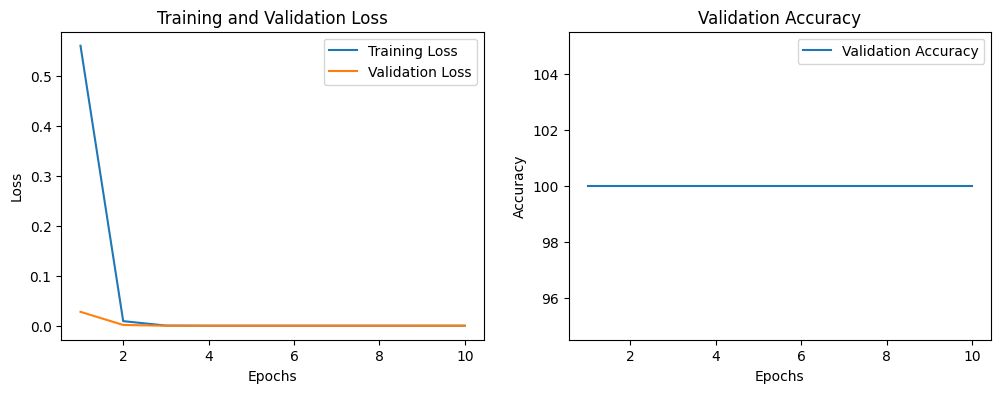

Test Accuracy: 100.00%


In [63]:
import torch.optim as optim

# Model Initialization
model = Gait1DCNN(num_classes=3)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Parameters
num_epochs = 10

# Training and Validating the Model, and Plotting the Metrics
train_losses, val_losses, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)
plot_metrics(train_losses, val_losses, val_accuracies)

# Testing the Model
test(model, test_loader)

In [64]:
# Save the model's state_dict
torch.save(model.state_dict(), "1D_CNN_model.pth")

# If you want to save more than just the model state_dict:
checkpoint = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    # include any other relevant information
}
torch.save(checkpoint, "1D_CNN_checkpoint.pth")